## 3. Meta-Learning Layer

> This is the brain that decides *what’s worth learning*.

### Components:

* Meta-feature extractor: entropy, volatility, predictability, residuals, etc.
* Transferability classifier: “Will an agent trained here generalize?”
* Predictability classifier: “Will an agent trained here learn *anything*?”
* Trust classifier: “Will the prediction of the base model be correct?”

### Landmarks:
* Transferability classifier
* Trust classifier

### Next Steps:
* Curriculum similarity & residual forecasting (under development)


This filters **which episodes are learnable, reusable, and worth spending resources on.**


In [1]:
import jupyter

C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gymnasium as gym

from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from scipy.stats import skew, kurtosis, entropy
from statsmodels.stats.diagnostic import acorr_ljungbox

from src.utils.system import boot
from src.defaults import RANDOM_SEEDS, TOP2_STOCK_BY_SECTOR
from tracker import OHLCV_DF, EpisodeTracker, EnvironmentTracker, AgentTracker



In [3]:
# Helper functions ====================
import numpy as np

def compute_returns_curve(curve):
    returns = np.diff(curve) / curve[:-1]
    return returns

def sharpe_ratio(returns, risk_free_rate=0.0):
    excess = returns - risk_free_rate
    return np.mean(excess) / (np.std(excess) + 1e-8)

def sortino_ratio(returns, risk_free_rate=0.0):
    returns = np.array(returns)
    excess = returns - risk_free_rate
    downside = excess[excess < 0]
    
    # Avoid division by zero: if no downside, assume very small downside deviation
    if len(downside) == 0:
        downside_std = 1e-8
    else:
        downside_std = np.std(downside)
    
    return np.mean(excess) / downside_std


def calmar_ratio(returns_curve):
    total_return = returns_curve[-1] / returns_curve[0] - 1
    drawdown = np.maximum.accumulate(returns_curve) - returns_curve
    max_drawdown = np.max(drawdown) / returns_curve[0]
    return total_return / (max_drawdown + 1e-8)

def central_tendency_difference (mean,median,std):
    return abs(mean-median)/(abs(std))

In [4]:
import os
import json
import hashlib
from collections import defaultdict
STORAGE_PATH = "data/experiments/episode_benchmark_engine/runs.csv"


EXCLUDED_TICKERS = sorted(["CEG", "GEHC", "GEV", "KVUE", "SOLV"])

CONFIG = {
    "regressor": "RandomForestRegressor",
    "n_estimators": 300,
    "random_state": 314,
    "transaction_cost": 0,
}
LOOKBACK = 0
EPISODE_LENGTH = 50

RUN_SETTINGS = {
    "excluded_tickers": EXCLUDED_TICKERS,
    "cv_folds": 3,
    "lags": 5,
    "seed": 314,
    'total_timesteps':50_000,
    "episode": {
        "episode_length": EPISODE_LENGTH,
        "lookback": LOOKBACK,
    },
    "environment": {
        "market_features": ["close", "price_change", "volume_change"],
        "version": "v4",
        "lookback": LOOKBACK,
        "episode_length": EPISODE_LENGTH,
        "transaction_cost": 0,
    },
    "agent": {
        "model_class": "PPO",
        "policy_class": "MlpPolicy",
        "config": {
            "verbose": 1,
            "ent_coef":0.1,
            "policy_kwargs": 
                {
                
                    "net_arch": [64, 64]
                    }
                },
    },
}


class EpisodeBenchmark:
    def __init__(
        self,
        tickers=["AAPL"],
        config=CONFIG,
        run_settings=RUN_SETTINGS,
        start_date="2024-01-01",
    ):
        self.ohlcv_df = OHLCV_DF.copy()
        self.tickers = tickers  # Force test with AAPL
        self.start_date = start_date


        self.config = CONFIG.copy()
        self.config.update(config)
        
        self.run_settings = RUN_SETTINGS.copy()
        self.run_settings.update(run_settings)
        self.run_settings['environment']['market_features'].sort()
        
        self.ep_tracker = EpisodeTracker()
        self.env_tracker = EnvironmentTracker()
        self.agent_tracker = AgentTracker()
        
        self.boot()
        
    def boot(self):
        if os.path.exists(STORAGE_PATH):
            self.completed_runs_df = pd.read_csv(STORAGE_PATH)

            self.completed_hashes = set(self.completed_runs_df["run_hash"].unique())
            self.seen_seeds = defaultdict(set)
            for _, row in self.completed_runs_df.iterrows():
                self.seen_seeds[row["run_hash"]].add(row["seed"])
        else:
            self.completed_runs_df = pd.DataFrame()
            self.completed_hashes = set()
            self.seen_seeds = defaultdict(set)

    def compute_run_hash(self, agent_id, train_episode_id,train_environment_id):
        market_features =self.run_settings['environment']['market_features']
        market_features.sort()
        payload = {
            "agent_id": agent_id,
            "episode_id": train_episode_id,
            "environment_id":train_environment_id,
            "timesteps": self.run_settings['total_timesteps'],
            "lookback":self.run_settings['episode']['lookback'],
            "episode_length":self.run_settings['episode']['episode_length'],
            "market_features":json.dumps(market_features)
        }
        return hashlib.md5(json.dumps(payload, sort_keys=True).encode()).hexdigest()
    
    def extract_agent_diagnostics(self,env, model, mode="train"):
        """
        Runs agent through environment and extracts residual diagnostics
        from reward trajectory, wallet progression, and optionally oracle and market.
        """
        rewards = []
        residuals_oracle = []
        obs = env.reset()[0]
        done = False

        oracle_progress = []
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, info = env.step(action)
            rewards.append(reward)

            # Oracle fallback
            oracle_score = info.get("oracle_score", None)
            if oracle_score is not None:
                oracle_progress.append(oracle_score)
                residuals_oracle.append(oracle_score - reward)
            else:
                oracle_progress.append(abs(reward))

        # Agent vs Oracle residuals
        if residuals_oracle:
            r_oracle = np.array(residuals_oracle)
        else:
            smoothed = pd.Series(rewards).rolling(window=5, min_periods=1).mean()
            r_oracle = np.array(rewards) - smoothed.values

        # Agent vs Market residuals
        agent_returns = np.array(env.wallet_progress)
        market_returns = np.array(env.market_progress)
        r_market = agent_returns - market_returns

        # Daily returns
        returns = pd.Series(agent_returns).pct_change().dropna().values
        market_pct_returns = pd.Series(market_returns).pct_change().dropna().values

        diagnostics = {
            f"{mode}_total_reward": env.total_reward,
            f"{mode}_wallet":env.wallet,
            f"{mode}_market":env.market_progress[-1],

            # Residuals vs Oracle
            f"{mode}_resid_oracle_std": np.std(r_oracle),
            f"{mode}_resid_oracle_skew": skew(r_oracle),
            f"{mode}_resid_oracle_kurtosis": kurtosis(r_oracle),
            f"{mode}_resid_oracle_acf1": pd.Series(r_oracle).autocorr(lag=1),
            f"{mode}_resid_oracle_mean": np.mean(r_oracle),
            f"{mode}_resid_oracle_median": np.median(r_oracle),
            f"{mode}_resid_oracle_max": np.max(r_oracle),
            f"{mode}_resid_oracle_min": np.min(r_oracle),
            f"{mode}_ljung_oracle_pval": (
                acorr_ljungbox(r_oracle, lags=[min(10, len(r_oracle) - 1)], return_df=True).iloc[0]['lb_pvalue']
                if len(r_oracle) > 10 else np.nan
            ),

            # Residuals vs Market
            f"{mode}_resid_market_std": np.std(r_market),
            f"{mode}_resid_market_skew": skew(r_market),
            f"{mode}_resid_market_kurtosis": kurtosis(r_market),
            f"{mode}_resid_market_acf1": pd.Series(r_market).autocorr(lag=1),
            f"{mode}_resid_market_mean": np.mean(r_market),
            f"{mode}_resid_market_median": np.median(r_market),
            f"{mode}_resid_market_max": np.max(r_market),
            f"{mode}_resid_market_min": np.min(r_market),
            f"{mode}_ljung_market_pval": (
                acorr_ljungbox(r_market, lags=[min(10, len(r_market) - 1)], return_df=True).iloc[0]['lb_pvalue']
                if len(r_market) > 10 else np.nan
            ),

            # Financial performance
            f"{mode}_sharpe": sharpe_ratio(returns),
            f"{mode}_sortino": sortino_ratio(returns),
            f"{mode}_calmar": calmar_ratio(agent_returns),
            f"{mode}_market_sharpe": sharpe_ratio(market_pct_returns),
            f"{mode}_market_sortino": sortino_ratio(market_pct_returns),
            f"{mode}_market_calmar": calmar_ratio(market_returns),
        }

        return diagnostics


    def correlation_with_test_result(self,test_result_feature="test_total_reward"):
        pddf = self.completed_runs_df.copy()
        
        cols_to_drop = [col for col in pddf.columns if col.startswith('test_') and col != test_result_feature]
        pddf_cleaned = pddf.drop(columns=cols_to_drop)

        correlations = pddf_cleaned.corr(numeric_only=True)[test_result_feature].sort_values(ascending=False)
        
        return correlations
    
    def describe(self, feature =None):
        descriptions = {
            "resid_mean": 
                "Mean of the residuals between agent and oracle/market.\n"
                "- Ideal: Close to 0 (no bias).\n"
                "- Positive: agent tends to overperform the benchmark.\n"
                "- Negative: consistent underperformance.",

            "resid_std": 
                "Standard deviation of residuals (volatility of difference).\n"
                "- Ideal: Low (stable excess performance).\n"
                "- High: unstable or noisy relative performance.",

            "resid_acf1": 
                "Autocorrelation at lag 1 of residuals.\n"
                "- Ideal: Close to 0 (no pattern).\n"
                "- Positive: persistent patterns (possibly exploitable).\n"
                "- Negative: mean-reverting behavior.",

            "resid_min": 
                "Minimum residual — worst case vs benchmark.\n"
                "- Ideal: Not too negative.\n"
                "- Negative: large underperformance at some point.",

            "resid_max": 
                "Maximum residual — best case vs benchmark.\n"
                "- Ideal: High (agent strongly beats the benchmark).",

            "resid_skew": 
                "Skewness of residual distribution.\n"
                "- Ideal: Slightly positive (more upside extremes).\n"
                "- Negative: heavier downside risks.",

            "resid_kurtosis": 
                "Kurtosis of residuals — fat tails.\n"
                "- Ideal: Moderate (3 is normal).\n"
                "- High: rare but extreme performance differences.",

            "resid_ljung_pval": 
                "Ljung-Box test p-value for autocorrelation in residuals.\n"
                "- Ideal: > 0.05 (no significant autocorrelation).\n"
                "- Low: residuals have autocorrelation (potential inefficiency).",

            "sharpe": 
                "Sharpe ratio — risk-adjusted return.\n"
                "- Ideal: High (>1 good, >2 excellent).\n"
                "- Negative: losing money or volatile with low return.",

            "sortino": 
                "Sortino ratio — like Sharpe but penalizes only downside risk.\n"
                "- Ideal: High (>1).\n"
                "- More robust than Sharpe when upside is volatile.",

            "calmar": 
                "Calmar ratio — return / max drawdown.\n"
                "- Ideal: High (>1).\n"
                "- Penalizes deep losses more than volatility-based ratios.",
        }
        if feature !=None:
            print(descriptions.get(feature, "No description available for this feature."))
        else:
            for k,v in descriptions.items():
                print(v)
                print('')
                
    def run(self, tickers=None):
        # Configurations =============================
        config = self.config
        run_settings = self.run_settings

        # Feature Extraction Loop ====================
        features, targets, metadata, runs = [], [], [], []
        ohlcv_df = self.ohlcv_df.copy()

        if tickers == None:
            tickers = self.tickers
        
        seed = 314
        boot(seed)
        
        for symbol in tqdm(tickers):
            df = ohlcv_df[ohlcv_df["symbol"] == symbol].sort_values("date").copy()
            df = df[df["date"] > self.start_date]
            df = df.iloc[: -self.run_settings["episode"]["episode_length"]]
            months = df["month"].unique()
            
            for i  in range(len(months)):
                try:

                    target_date = str(months[i]) + "-01"
                    
                    episodes = self.ep_tracker.findEpisode(
                        target_date,
                        symbol,
                        episode_length=self.run_settings["episode"]["episode_length"],
                        lookback=self.run_settings["episode"]["lookback"],
                        mode="both",
                    )

                    train_episode = episodes["train"]
                    test_episode = episodes["test"]

                    env_tracker = EnvironmentTracker()

                    train_env_config = {
                        "ticker": symbol,
                        "n_timesteps": self.run_settings["episode"]["episode_length"],
                        "lookback": self.run_settings["episode"]["lookback"],
                        "market_features":self.run_settings['environment']['market_features'],
                        "seed": seed,
                        "start_idx": train_episode["df_start_iloc"],  # type: ignore
                    }
                    test_env_config = train_env_config.copy()
                    test_env_config["start_idx"] = test_episode["df_start_iloc"] # type: ignore

                    env_info = env_tracker.findEnvironment(
                        version=self.run_settings['environment']['version'], config=train_env_config
                    )
                    
                    train_env = env_info["environment"]
                    #train_config["start_idx"] = test_episode["start_idx"]
                    
                    test_env = env_tracker.findEnvironment(
                        version=self.run_settings['environment']['version'], config=test_env_config
                    )
                   
                    test_env = test_env["environment"]

                    tracker = AgentTracker()
                    
                    agent = tracker.findAgent(
                        **self.run_settings['agent']
                   
                    )
                    
                    run_hash = self.compute_run_hash(
                        agent_id=agent["id"],
                        train_episode_id=train_episode["id"],
                        train_environment_id=env_info['id']
                    )
                    
                    if run_hash in self.completed_hashes and seed in self.seen_seeds[run_hash]:
                        
                        continue  # Skip
                    print('will run',run_hash)    
                    _model = agent["model"].boot(train_env)
                    _model.learn(total_timesteps=self.run_settings['total_timesteps'])
                    
                    # diagnostics 
                     
                    train_diagnostics =self.extract_agent_diagnostics(train_env,_model,mode="train")
                    test_diagnostics =self.extract_agent_diagnostics(test_env,_model,mode="test")
                    full_diagnostics = {
                        **train_diagnostics,
                        **test_diagnostics
                    }
                    #ddf.append(full_diagnostics)
                    results =  {
                        'run_hash':run_hash,
                        'seed':seed,
                        'target_date':target_date,
                            "agent":self.run_settings['agent']['model_class'],
                            "policy":self.run_settings['agent']['policy_class'],
                            "env_version":env_info['version'],
                            "train_episode_id": train_episode["id"],
                            "test_episode_id":  test_episode["id"],
                            "total_timesteps": self.run_settings['total_timesteps'],
                            "ticker": symbol,
                            "target_date": target_date,
                            "environment_id": env_info["id"],
                            "agent_id": agent["id"],
                            "episode_length":self.run_settings['episode']['episode_length'],
                            "lookback":self.run_settings['episode']['lookback'],
                            "market_features":json.dumps(self.run_settings['environment']['market_features']),
                            **full_diagnostics
                        }
                    if run_hash in self.completed_hashes and seed in self.seen_seeds[run_hash]:
                        print(f"Skipping already completed run {run_hash} with seed {seed}")
                    else:
                        self.completed_runs_df = pd.concat([self.completed_runs_df, pd.DataFrame([results])], ignore_index=True)
                        self.completed_hashes.add(run_hash)
                        self.seen_seeds[run_hash].add(seed)
                        self.completed_runs_df.to_csv(STORAGE_PATH,index=False)

                    # runs.append(
                    #     {
                    #         "agent":self.run_settings['agent']['model_class'],
                    #         "policy":self.run_settings['agent']['policy_class'],
                    #         "env_version":"v2",
                     
                    #         "train_episode_id": train_episode["id"],
                    #         "test_episode_id":  test_episode["id"],
                    #         "total_timesteps": self.run_settings['total_timesteps'],
                    #         "ticker": symbol,
                    #         "target_date": target_date,
                    #         "environment_id": env_info["id"],
                    #         "agent_id": agent["id"],
                    #         "model": _model,
                    #         "train_env": train_env,
                    #         "test_env": test_env,
                    #         **full_diagnostics
                    #     }
                    # )
               
                    print('next')
                except Exception as e:
                    print(f"Skipping {symbol} {months[i]} due to error: {e}")
             
        return self.completed_runs_df    



In [102]:
import pandas as pd
import numpy as np

# Load the completed runs from the benchmark storage path
storage_path = STORAGE_PATH
df = pd.read_csv(storage_path)

# Step 1: Group by run_hash and compute median per hash (across seeds)
df_grouped = df.groupby("run_hash").median(numeric_only=True).reset_index()

# Step 2: Define the binary target based on test_total_reward
df_grouped["target"] = (df_grouped["test_total_reward"] > 0).astype(int)

# Step 3: Select all train_* diagnostics (exclude non-feature fields)
train_features = [col for col in df_grouped.columns if col.startswith("train_")] #and col != "train_episode_id"]
train_features = [f for f in train_features if "reward" not in f]  # optionally exclude direct reward

# Step 4: Correlate with test_total_reward and select top-K features
correlations = df_grouped[train_features + ["test_total_reward"]].corr(numeric_only=True)["test_total_reward"]
top_k = correlations.abs().sort_values(ascending=False).drop("test_total_reward").head(15).index.tolist()

# Step 5: Build meta_df with top features and target
meta_df = df_grouped[top_k + ["target", "run_hash"]]

# Show the resulting meta_df
import ace_tools_open as tools; tools.display_dataframe_to_user(name="Meta DF for Transferability", dataframe=meta_df)


Meta DF for Transferability


Loading ITables v2.4.0 from the internet... (need help?)


In [103]:
correlations.sort_values(ascending=False)

test_total_reward              1.000000
train_episode_id               0.133924
train_resid_oracle_median      0.065495
train_sharpe                   0.051855
train_resid_market_acf1        0.048042
train_resid_market_min         0.036111
train_resid_oracle_acf1        0.032256
train_resid_market_median      0.021564
train_resid_oracle_min         0.008497
train_calmar                   0.008185
train_sortino                  0.007261
train_resid_oracle_kurtosis    0.001820
train_resid_oracle_max        -0.006603
train_resid_oracle_std        -0.006808
train_resid_oracle_skew       -0.008855
train_resid_market_mean       -0.009072
train_resid_oracle_mean       -0.013983
train_market_sharpe           -0.025146
train_market                  -0.026245
train_ljung_market_pval       -0.027851
train_resid_market_std        -0.031006
train_resid_market_kurtosis   -0.031729
train_resid_market_max        -0.032537
train_wallet                  -0.037360
train_market_sortino          -0.037513


In [104]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from environments import AutoFeatureScaler
class Classifier:
    def __init__(self,X,y,test_size=0.5,random_state=314, cls=RandomForestClassifier, cls_kwargs={"n_estimators":200}):
        # Step 1: Drop metadata column and split
        self.X = X
        self.y = y
        self.test_size=test_size
        self.random_state =random_state
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=self.test_size, random_state=self.random_state, stratify=self.y)

        # Step 2: Impute missing values with median
        imputer = SimpleImputer(strategy="median")
        self.X_train_imputed = imputer.fit_transform(self.X_train)
        self.X_test_imputed = imputer.transform(self.X_test)
        
        # Step 3: Scale features
        self.scaler = AutoFeatureScaler()
        self.X_train_scaled = self.scaler.fit_transform(pd.DataFrame(self.X_train_imputed,columns=X.columns))
        self.X_test_scaled = self.scaler.transform(pd.DataFrame(self.X_test_imputed,columns=X.columns))

        # Step 4: Train RandomForestClassifier
        self.model = cls(**cls_kwargs, random_state=self.random_state)
        self.model.fit(self.X_train_scaled, self.y_train)

        
        
    def report(self):
        # Step 5: Predict and evaluate
        y_pred = self.model.predict(self.X_test_scaled)
        report = classification_report(self.y_test, y_pred, output_dict=True)
        conf_matrix = confusion_matrix(self.y_test, y_pred)

        # Display confusion matrix
        disp = ConfusionMatrixDisplay(conf_matrix, display_labels=self.model.classes_)
        disp.plot(cmap="Blues", values_format="d")

        return report
        

In [105]:
meta_df

,train_episode_id,train_resid_oracle_median,train_resid_market_skew,train_sharpe,train_resid_market_acf1,train_market_calmar,train_ljung_oracle_pval,train_market_sortino,train_wallet,train_resid_market_min,train_resid_market_max,train_resid_oracle_acf1,train_resid_market_kurtosis,train_resid_market_std,train_ljung_market_pval,target,run_hash
0,1955.0,-0.010599,-0.894929,0.547120,0.990224,1.316195,0.024172,0.284116,1.174807,0.000000,0.108892,0.106735,-0.387328,0.031775,4.532429e-38,1,00a95a9b5451454daa0ac9db60bd691d
1,1945.0,-0.018633,-1.475500,0.334554,0.917396,1.398947,0.783162,0.173898,1.096235,0.000000,0.086521,-0.100667,2.361356,0.021447,1.015872e-19,1,016fccf651bb1b6d9aa31f15514bf258
2,1589.0,-0.006134,-0.169947,0.682210,0.994724,1.067771,0.799035,0.255598,1.131208,0.000000,0.170822,-0.052397,-1.496188,0.059310,1.153777e-57,0,017b0b5d0e3e82f4ba8d3097d83385dd
3,1775.0,-0.018425,0.474277,0.453463,0.982456,2.134285,0.191305,0.422244,1.212779,-0.005190,0.074589,0.132049,-1.689779,0.031040,5.583450e-49,0,026596533ad738b03fc2de00c9defd23
4,1761.0,-0.010516,-0.495994,0.504403,0.989764,-0.121868,0.003933,-0.007153,1.240333,0.000000,0.250759,0.229139,-0.241383,0.063436,8.162502e-34,1,028f8509f16277d509d114f4f7a8fe31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,1741.0,-0.012568,0.087627,0.535688,0.995091,-0.391892,0.010903,-0.051236,1.307723,0.000000,0.343175,-0.229720,-1.390117,0.105685,2.264627e-54,0,fb92e763f472a010e57d43280f436f37
326,1535.0,-0.019255,-0.640574,0.576796,0.994875,1.751627,0.999999,0.410906,1.319212,0.000000,0.199856,-0.015974,-0.791030,0.060125,5.421148e-46,0,fcf4d4e1a310c163afd3fca015d410aa
327,1617.0,-0.019328,0.110490,0.113445,0.983629,-0.949297,0.902113,-0.379463,1.023650,0.000000,0.161095,-0.123482,-0.683965,0.043378,5.298711e-39,0,fe80f74197b0ed50efb94aabb6728ea9
328,1479.0,-0.030593,0.457152,0.445751,0.974407,2.043600,0.145646,0.283078,1.178826,-0.008163,0.084572,-0.009836,-1.237643,0.029652,1.305387e-50,0,feafc12f26f50d22997b062328acb58e


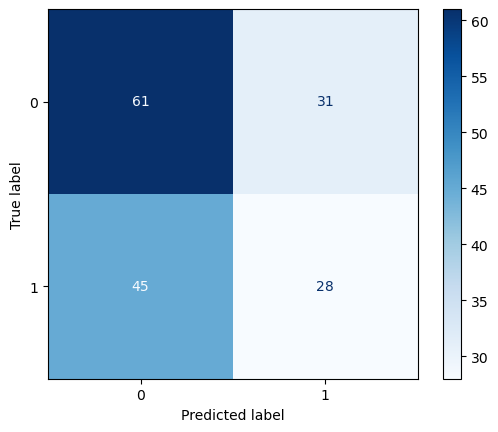

In [106]:
X = meta_df.drop(columns=["target", "run_hash"])
y = meta_df["target"]
classifier = Classifier(X,y)
report = classifier.report()

##  Now we ask: 
What patterns persist across time?


#### Next steps:

* Curriculum Similarity — do similar episodes yield transferable models?

* Forecast Residuals — can we estimate the signal-to-noise of episode t+1?

* Prediction Trust — meta-classifier to estimate confidence in the main prediction?



In [232]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances

runs_df = df.copy()
runs_df.replace([np.inf, -np.inf], np.nan, inplace=True)
runs_df.dropna(inplace=True)  
# Group by run_hash and median across seeds
runs_grouped = runs_df.groupby("run_hash").median(numeric_only=True).reset_index()
runs_grouped["target"] = (runs_grouped["test_total_reward"] > 0).astype(int)

# Identify available train_* and test_* features
train_cols = [col for col in runs_grouped.columns if col.startswith("train_") and "reward" not in col ]# and "train_episode_id" not in col]
test_cols  = [col for col in runs_grouped.columns if col.startswith("test_") and "reward" not in col ]# and "test_episode_id" not in col]


# Rename features to common base names (drop "train_" and "test_")
train_base = [c.replace("train_", "") for c in train_cols]
test_base = [c.replace("test_", "") for c in test_cols]

# Build aligned dataframes
train_df = runs_grouped[train_cols].copy()
train_df.columns = train_base

test_df = runs_grouped[test_cols].copy()
test_df.columns = test_base

# Standardize features to compute cosine similarity
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

# Compute 1 - cosine similarity (distance)
similarity = np.diag(cosine_similarity(train_scaled, test_scaled))
runs_grouped["curriculum_similarity"] = similarity

# Build updated meta_df with curriculum similarity
meta_df_enriched = runs_grouped[top_k + ["target", "run_hash"]].copy()
meta_df_enriched["curriculum_similarity"] = similarity

# Show enriched dataframe
import ace_tools_open as tools; tools.display_dataframe_to_user(name="Meta DF with Curriculum Similarity", dataframe=meta_df_enriched)

Meta DF with Curriculum Similarity


Loading ITables v2.4.0 from the internet... (need help?)


In [233]:
meta_df_enriched.sort_values(by="curriculum_similarity",ascending=False)

,train_episode_id,train_resid_oracle_median,train_resid_market_skew,train_sharpe,train_resid_market_acf1,train_market_calmar,train_ljung_oracle_pval,train_market_sortino,train_wallet,train_resid_market_min,train_resid_market_max,train_resid_oracle_acf1,train_resid_market_kurtosis,train_resid_market_std,train_ljung_market_pval,target,run_hash,curriculum_similarity
222,1465.0,-0.004018,-1.506781,0.271001,0.958912,1.627040,0.003382,0.298151,1.040648,-0.018141,0.052772,0.095249,0.990272,0.019232,1.348298e-31,1,b3ad9b450d01e936522f4f5ea497f3d7,0.904020
182,1447.0,-0.017019,-4.357099,0.346489,0.805926,1.825444,0.497311,0.340098,1.000000,0.000000,0.033619,0.007775,18.267927,0.005830,6.354017e-02,0,91aba5a1c4576b50d5a0bb589c9c514b,0.856262
167,1911.0,0.000000,0.223730,0.221871,0.876388,0.750563,0.401928,0.120086,1.057958,-0.028676,0.052645,0.235972,-0.483299,0.017704,5.593706e-20,0,81d0abf8082f9d5548c7c0ffa3ac390d,0.795058
211,1643.0,-0.008984,-0.127508,0.038149,0.845189,-0.948317,0.997548,-0.173130,1.006131,0.000000,0.118627,-0.122063,0.068018,0.026314,1.063042e-11,1,ab03e2db49498ac7240c3deeb6d46dba,0.785989
245,1523.0,-0.015705,0.740858,0.398249,0.914737,0.245788,0.929725,0.038052,1.206558,-0.029114,0.180804,-0.013124,0.618743,0.048499,1.819252e-15,1,c5e400c5276d9832850c72af08a0cae2,0.785864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,1713.0,-0.027523,-0.295536,0.427309,0.989899,1.356747,0.486059,0.285020,1.385569,0.000000,0.256553,-0.119878,-1.156341,0.075620,1.190096e-44,0,c2fd08e2e6516334760ec92f17a31626,-0.495306
55,1769.0,-0.010382,0.025827,0.518202,0.997013,0.344931,0.725583,0.133010,1.397656,0.000000,0.346960,-0.037543,-1.373762,0.116554,2.978198e-54,0,2444d93d973c199af35086f0bb8e978f,-0.507186
37,1575.0,-0.026456,0.364547,0.586387,0.990679,1.351433,0.689241,0.202995,1.224700,-0.001782,0.159896,0.102273,-1.466212,0.064383,4.185993e-58,0,1af5044425a3463ef4b0ef869278f00e,-0.519481
161,1771.0,-0.007712,-0.218316,0.575900,0.995861,1.133607,0.851468,0.215801,1.419272,0.000000,0.320019,-0.070774,-1.115005,0.091490,9.621273e-51,0,7941dd62afbfe5f3fccd68f6eccc392b,-0.577741


In [234]:
meta_df_enriched.corr(numeric_only=True)['curriculum_similarity'].sort_values(ascending=False)

curriculum_similarity          1.000000
train_resid_market_kurtosis    0.294917
train_resid_oracle_median      0.254886
target                         0.198285
train_ljung_market_pval        0.163021
train_episode_id               0.022821
train_market_calmar            0.008063
train_resid_oracle_acf1       -0.009412
train_ljung_oracle_pval       -0.012594
train_resid_market_skew       -0.026258
train_market_sortino          -0.035989
train_resid_market_std        -0.371816
train_resid_market_max        -0.409872
train_wallet                  -0.411896
train_resid_market_min        -0.450437
train_resid_market_acf1       -0.477638
train_sharpe                  -0.491743
Name: curriculum_similarity, dtype: float64

In [235]:
"""
Predictability residuals 
For each test episode:

Get past N days of OHLCV data (e.g., 200 days before the episode)

Train a small LSTM on that to predict next-day close or return

Use it to forecast the full test episode (50 steps)

Compare predicted vs. actual:

MSE

Residual std

R²

Entropy of residuals

Save all as meta-features
"""

'\nPredictability residuals \nFor each test episode:\n\nGet past N days of OHLCV data (e.g., 200 days before the episode)\n\nTrain a small LSTM on that to predict next-day close or return\n\nUse it to forecast the full test episode (50 steps)\n\nCompare predicted vs. actual:\n\nMSE\n\nResidual std\n\nR²\n\nEntropy of residuals\n\nSave all as meta-features\n'

In [236]:
import numpy as np

# Sort and reset index
aapl_df = OHLCV_DF[OHLCV_DF['symbol']=="AAPL"].copy()
aapl_df["date"] = pd.to_datetime(aapl_df["date"])
aapl_df = aapl_df.sort_values("date").reset_index(drop=True)

# Constants
EPISODE_LENGTH = 120
TEST_EPISODE_IDX = 1354
LOOKBACK_DAYS = 200



In [237]:
ep_tracker = EpisodeTracker()
ep = ep_tracker.load_instance(TEST_EPISODE_IDX)

"""

df_end_iloc': 704,
 'df_start_iloc': 584,
 'df_target_date_iloc': 584,
 'end_date': '2024-10-23 00:00:00',
 'episode_length': 120,
 'mode': 'test',
 'start_date': '2024-05-02 00:00:00',
 'target_date': '2024-05-01',
 'ticker': 'AAPL',
 
Plan:
Use AAPL data from index 384 to 584 (200 timesteps prior) to train LSTM

Predict index 584 → 704 (episode 10)

Compare predictions to actual close prices

Extract meta-features from residuals
"""
split_idx = ep['df_start_iloc'] # 584
start_idx = split_idx-LOOKBACK_DAYS
end_idx   = ep['df_end_iloc'] # 704
end_idx-split_idx,split_idx-start_idx

(50, 200)

In [238]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

# LSTM model definition
class LSTMForecaster(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, output_dim=1):
        super(LSTMForecaster, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.linear(lstm_out[:, -1, :])
        return out

# Prepare LSTM input-output sequences
def create_sequences(data, window_size=10):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        seq = data[i:i+window_size]
        label = data[i+window_size]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

# Step 1: Slice training and test closes
window_size = 10
train_prices = aapl_df.iloc[start_idx:split_idx]["close"].values.reshape(-1, 1)
test_prices = aapl_df.iloc[split_idx:end_idx]["close"].values.reshape(-1, 1)

# Step 2: Normalize
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_prices)
test_scaled = scaler.transform(test_prices)

# Step 3: Create LSTM sequences
X_train, y_train = create_sequences(train_scaled, window_size=window_size)
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)

# Step 4: Train the LSTM
model = LSTMForecaster(input_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Reshape for batch_size x seq_len x input_dim
X_train_torch = X_train_torch.view(X_train_torch.shape[0], X_train_torch.shape[1], 1)

# Training loop
for epoch in range(30):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_torch)
    loss = criterion(output, y_train_torch)
    loss.backward()
    optimizer.step()

# Step 5: Recursive Forecasting
model.eval()
last_window = torch.tensor(train_scaled[-window_size:], dtype=torch.float32).view(1, window_size, 1)
predictions = []

with torch.no_grad():
    for _ in range(120):  # Forecast 120 steps ahead
        pred = model(last_window)
        predictions.append(pred.item())
        new_input = torch.cat((last_window[:, 1:, :], pred.view(1, 1, 1)), dim=1)
        last_window = new_input

# Inverse transform predictions to original scale
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
actual_prices = test_prices.flatten()

predicted_prices[:5], actual_prices[:5]


(array([183.90893633, 183.5339687 , 183.17547706, 182.87303772,
        182.63469082]),
 array([185.64, 184.25, 181.91, 181.18, 185.56]))

In [239]:
aligned_predicted = predicted_prices[-len(test_prices):]
aligned_actual = test_prices.flatten()  # already correct length

In [240]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = aligned_actual - aligned_predicted

# Compute diagnostics
forecast_residuals = {
    "forecast_residual_mean": np.mean(residuals),
    "forecast_residual_std": np.std(residuals),
    "forecast_residual_skew": skew(residuals),
    "forecast_residual_kurtosis": kurtosis(residuals),
    "forecast_residual_acf1": pd.Series(residuals).autocorr(lag=1),
    "forecast_residual_ljung_pval": (
        acorr_ljungbox(residuals, lags=[min(10, len(residuals) - 1)], return_df=True).iloc[0]['lb_pvalue']
        if len(residuals) > 10 else np.nan
    ),
}

# Merge into meta_df_enriched (append to the last row as test)
#for key, value in forecast_residuals.items():
#    meta_df_enriched.loc[meta_df_enriched.index[-1], key] = value

# Save updated file
#meta_df_enriched.to_csv("/mnt/data/meta_df_enriched_with_forecast.csv", index=False)

#import ace_tools
forecast_residuals

{'forecast_residual_mean': 1.8678562718152756,
 'forecast_residual_std': 6.617457409005365,
 'forecast_residual_skew': -0.6232952836000293,
 'forecast_residual_kurtosis': -0.013783714957087856,
 'forecast_residual_acf1': 0.9503249165576926,
 'forecast_residual_ljung_pval': 8.509439373836561e-30}

In [241]:
# Merge into meta_df_enriched (append to the last row as test)
#for key, value in forecast_residuals.items():
#    meta_df_enriched.loc[meta_df_enriched.index[-1], key] = value

# Save updated file
#meta_df_enriched.to_csv("/mnt/data/meta_df_enriched_with_forecast.csv", index=False)

meta_df_enriched[meta_df_enriched['train_episode_id'] == TEST_EPISODE_IDX +1]
row_idx = meta_df_enriched[meta_df_enriched['train_episode_id'] == TEST_EPISODE_IDX + 1].index
row_idx = row_idx[0]

for key, value in forecast_residuals.items():
    meta_df_enriched.loc[row_idx, key] = value
    
meta_df_enriched.to_csv('meta_df_enriched.csv')

In [242]:
runs_df[runs_df['test']]


KeyError: 'test'

In [243]:
# Bulk forecast residuals
ep_tracker = EpisodeTracker()

for TRAIN_EPISODE_IDX in runs_df['train_episode_id'].unique():
    TEST_EPISODE_IDX = int(TRAIN_EPISODE_IDX)+1
    ep = ep_tracker.load_instance(TEST_EPISODE_IDX)

    split_idx = ep['df_start_iloc'] # 584
    start_idx = split_idx-LOOKBACK_DAYS
    end_idx   = ep['df_end_iloc'] # 704


    # Step 1: Slice training and test closes
    window_size = 10
    train_prices = aapl_df.iloc[start_idx:split_idx]["close"].values.reshape(-1, 1)
    test_prices = aapl_df.iloc[split_idx:end_idx]["close"].values.reshape(-1, 1)

    # Step 2: Normalize
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_prices)
    test_scaled = scaler.transform(test_prices)

    # Step 3: Create LSTM sequences
    X_train, y_train = create_sequences(train_scaled, window_size=window_size)
    X_train_torch = torch.tensor(X_train, dtype=torch.float32)
    y_train_torch = torch.tensor(y_train, dtype=torch.float32)

    # Step 4: Train the LSTM
    model = LSTMForecaster(input_dim=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Reshape for batch_size x seq_len x input_dim
    X_train_torch = X_train_torch.view(X_train_torch.shape[0], X_train_torch.shape[1], 1)

    # Training loop
    for epoch in range(30):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_torch)
        loss = criterion(output, y_train_torch)
        loss.backward()
        optimizer.step()

    # Step 5: Recursive Forecasting
    model.eval()
    last_window = torch.tensor(train_scaled[-window_size:], dtype=torch.float32).view(1, window_size, 1)
    predictions = []

    with torch.no_grad():
        for _ in range(120):  # Forecast 120 steps ahead
            pred = model(last_window)
            predictions.append(pred.item())
            new_input = torch.cat((last_window[:, 1:, :], pred.view(1, 1, 1)), dim=1)
            last_window = new_input

    # Inverse transform predictions to original scale
    predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    actual_prices = test_prices.flatten()

    predicted_prices[:5], actual_prices[:5]


    aligned_predicted = predicted_prices[-len(test_prices):]
    aligned_actual = test_prices.flatten()  # already correct length

    residuals = aligned_actual - aligned_predicted

    # Compute diagnostics
    forecast_residuals = {
        "forecast_residual_mean": np.mean(residuals),
        "forecast_residual_std": np.std(residuals),
        "forecast_residual_skew": skew(residuals),
        "forecast_residual_kurtosis": kurtosis(residuals),
        "forecast_residual_acf1": pd.Series(residuals).autocorr(lag=1),
        "forecast_residual_ljung_pval": (
            acorr_ljungbox(residuals, lags=[min(10, len(residuals) - 1)], return_df=True).iloc[0]['lb_pvalue']
            if len(residuals) > 10 else np.nan
        ),
    }

    # Merge into meta_df_enriched (append to the last row as test)
    #for key, value in forecast_residuals.items():
    #    meta_df_enriched.loc[meta_df_enriched.index[-1], key] = value

    # Save updated file
    #meta_df_enriched.to_csv("/mnt/data/meta_df_enriched_with_forecast.csv", index=False)

    meta_df_enriched[meta_df_enriched['train_episode_id'] == TEST_EPISODE_IDX -1]
    row_idx = meta_df_enriched[meta_df_enriched['train_episode_id'] == TEST_EPISODE_IDX -1].index
    try:
        row_idx = row_idx[0]
    except:
        pass 
    
    for key, value in forecast_residuals.items():
        meta_df_enriched.loc[row_idx, key] = value
    print('oh yeah')

#meta_df_enriched.to_csv('meta_df_enriched.csv')

oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah
oh yeah


In [245]:
meta_df_enriched.to_csv('meta_df_enriched.csv')
pd.read_csv('meta_df_enriched.csv')
#meta_df_enriched

,Unnamed: 0,train_episode_id,train_resid_oracle_median,train_resid_market_skew,train_sharpe,train_resid_market_acf1,train_market_calmar,train_ljung_oracle_pval,train_market_sortino,train_wallet,...,train_ljung_market_pval,target,run_hash,curriculum_similarity,forecast_residual_mean,forecast_residual_std,forecast_residual_skew,forecast_residual_kurtosis,forecast_residual_acf1,forecast_residual_ljung_pval
0,0,1955.0,-0.010599,-0.894929,0.547120,0.990224,1.316195,0.024172,0.284116,1.174807,...,4.532429e-38,1,00a95a9b5451454daa0ac9db60bd691d,-0.301763,-12.071076,6.824996,0.410597,-1.264621,0.942761,4.942040e-40
1,1,1945.0,-0.018633,-1.475500,0.334554,0.917396,1.398947,0.783162,0.173898,1.096235,...,1.015872e-19,1,016fccf651bb1b6d9aa31f15514bf258,0.383518,-6.810848,9.716982,-0.044836,-0.870770,0.924392,3.015498e-40
2,2,1589.0,-0.006134,-0.169947,0.682210,0.994724,1.067771,0.799035,0.255598,1.131208,...,1.153777e-57,0,017b0b5d0e3e82f4ba8d3097d83385dd,-0.395057,9.473206,17.688635,-0.884541,0.361570,0.927993,6.242962e-29
3,3,1775.0,-0.018425,0.474277,0.453463,0.982456,2.134285,0.191305,0.422244,1.212779,...,5.583450e-49,0,026596533ad738b03fc2de00c9defd23,0.155318,-16.540589,6.853293,0.413242,-1.262260,0.943223,3.910664e-40
4,4,1761.0,-0.010516,-0.495994,0.504403,0.989764,-0.121868,0.003933,-0.007153,1.240333,...,8.162502e-34,1,028f8509f16277d509d114f4f7a8fe31,-0.033914,56.978047,6.762608,0.797494,-0.149412,0.936671,4.735886e-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,310,1741.0,-0.012568,0.087627,0.535688,0.995091,-0.391892,0.010903,-0.051236,1.307723,...,2.264627e-54,0,fb92e763f472a010e57d43280f436f37,-0.198526,-18.095558,14.520458,-0.078280,-0.158401,0.880896,3.049744e-15
311,311,1535.0,-0.019255,-0.640574,0.576796,0.994875,1.751627,0.999999,0.410906,1.319212,...,5.421148e-46,0,fcf4d4e1a310c163afd3fca015d410aa,-0.228037,-7.112050,6.824996,0.410597,-1.264621,0.942761,4.942040e-40
312,312,1617.0,-0.019328,0.110490,0.113445,0.983629,-0.949297,0.902113,-0.379463,1.023650,...,5.298711e-39,0,fe80f74197b0ed50efb94aabb6728ea9,-0.124428,20.560594,9.262499,-0.749588,-0.081664,0.889207,3.365975e-13
313,313,1479.0,-0.030593,0.457152,0.445751,0.974407,2.043600,0.145646,0.283078,1.178826,...,1.305387e-50,0,feafc12f26f50d22997b062328acb58e,0.177280,14.843919,11.047347,0.175142,-1.248409,0.956547,3.027083e-50


## Checkpoint:
### What Are We Actually Doing?
We’re trying to predict whether training on episode t will work on episode t+1.

**To do that, we:**
| Step | Episode              | Action                                                              |
| ---- | -------------------- | ------------------------------------------------------------------- |
| 1    | `t` (train episode)  | Extract features (residuals, stats, etc.)                           |
| 2    | `t+1` (test episode) | Forecast prices using a simple model                                |
| 3    | `t+1` (test episode) | Compute **forecast residuals** — how hard was this to predict?      |
| 4    |                      | Use this residual to label episode `t` as **"transferable or not"** |

**So:**
* We are not classifying episode t+1.
* We are using info about t+1 to judge whether t was a good training candidate.



In [246]:
#Train Predictive Classifier
# Goal: predict whether training on episode t will transfer well to t+1.

meta_df_extended=meta_df_enriched.copy() 

# Features (only those known at the end of t)
features = [col for col in meta_df_extended.columns if col.startswith('train_') or col.startswith('forecast_residual')]
X = meta_df_extended[features]
y = meta_df_extended['target']  # or agent advantage

# Clean + scale
X = X.replace([np.inf, -np.inf], np.nan).dropna()
X_scaled = StandardScaler().fit_transform(X)
y = y.loc[X.index]

# Train
model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X_scaled, y)

RandomForestClassifier(n_estimators=300, random_state=42)

<Axes: >

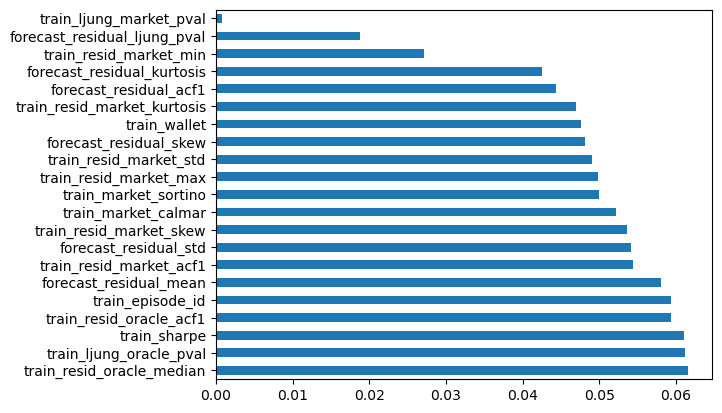

In [247]:
# Feature importances
importances = model.feature_importances_
feature_df = pd.Series(importances, index=X.columns).sort_values(ascending=False)
feature_df.plot(kind='barh')

In [248]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the enriched meta-dataset


# Drop infs and NaNs
meta_df_enriched = meta_df_enriched.replace([np.inf, -np.inf], np.nan).dropna()

# Select relevant features (known after episode t)
feature_cols = [col for col in meta_df_enriched.columns if col.startswith('train_') or col.startswith('forecast_residual')]
X = meta_df_enriched[feature_cols]
y = meta_df_enriched['target']  # This is whether training on t transferred well to t+1

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)

# Train classifier
clf = RandomForestClassifier(n_estimators=300, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluation
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)
feature_importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

import ace_tools_open as tools; tools.display_dataframe_to_user(name="Top Feature Importances", dataframe=feature_importances.head(20).to_frame("importance"))
report, conf_matrix


Top Feature Importances


Loading ITables v2.4.0 from the internet... (need help?)


({'0': {'precision': 0.5862068965517241,
   'recall': 0.7727272727272727,
   'f1-score': 0.6666666666666666,
   'support': 44.0},
  '1': {'precision': 0.5238095238095238,
   'recall': 0.3142857142857143,
   'f1-score': 0.39285714285714285,
   'support': 35.0},
  'accuracy': 0.569620253164557,
  'macro avg': {'precision': 0.555008210180624,
   'recall': 0.5435064935064935,
   'f1-score': 0.5297619047619048,
   'support': 79.0},
  'weighted avg': {'precision': 0.5585624909064456,
   'recall': 0.569620253164557,
   'f1-score': 0.5453586497890295,
   'support': 79.0}},
 array([[34, 10],
        [24, 11]], dtype=int64))

In [249]:
# Didn0't classify that well
ep

{'df_end_iloc': 841,
 'df_start_iloc': 791,
 'df_target_date_iloc': 791,
 'end_date': '2025-05-13 00:00:00',
 'episode_length': 50,
 'mode': 'test',
 'start_date': '2025-03-03 00:00:00',
 'target_date': '2025-03-01',
 'ticker': 'XOM',
 'df':             id symbol           timestamp       date    open     high     low  \
 159381  159382    XOM 2022-01-04 05:00:00 2022-01-04   64.13   66.185   64.10   
 159382  159383    XOM 2022-01-05 05:00:00 2022-01-05   66.50   67.610   66.48   
 159383  159384    XOM 2022-01-06 05:00:00 2022-01-06   68.00   68.480   67.07   
 159384  159385    XOM 2022-01-07 05:00:00 2022-01-07   68.52   69.180   67.98   
 159385  159386    XOM 2022-01-10 05:00:00 2022-01-10   68.97   69.170   67.95   
 ...        ...    ...                 ...        ...     ...      ...     ...   
 160217  160218    XOM 2025-05-06 04:00:00 2025-05-06  103.89  105.980  103.48   
 160218  160219    XOM 2025-05-07 04:00:00 2025-05-07  104.99  105.290  104.07   
 160219  160220    XO

In [250]:
import pandas as pd
import numpy as np
from arch import arch_model
from ruptures import Binseg
#from ruptures.costs import CostR
from scipy.stats import entropy
from sklearn.preprocessing import KBinsDiscretizer
from ace_tools_open import display_dataframe_to_user
new_features = []
episode_length=50

for idx, row in meta_df_enriched.iterrows():
    #train_episode_id = row["train_episode_id"]
    ep = ep_tracker.load_instance(row["train_episode_id"])
    episode_df = ep['df'].iloc[ep['df_start_iloc']:ep['df_end_iloc']]#aapl_df.iloc[train_episode_id : train_episode_id + episode_length]
    prices = episode_df["close"].values
    returns = np.diff(prices) / prices[:-1]

    features = {
        "train_episode_id": train_episode_id,
    }

    # === Volatility-based features ===
    features["volatility_std"] = np.std(returns)
    features["volatility_mean"] = np.mean(np.abs(returns))
    try:
        hist, _ = np.histogram(returns, bins=10, density=True)
        features["volatility_entropy"] = entropy(hist + 1e-8)
    except Exception:
        features["volatility_entropy"] = np.nan

    # === GARCH model ===
    try:
        am = arch_model(returns * 100, vol="Garch", p=1, q=1, rescale=False)
        res = am.fit(disp="off")
        features["garch_volatility_mean"] = np.mean(res.conditional_volatility)
        features["garch_residual_std"] = np.std(res.resid)
        features["garch_loglik"] = res.loglikelihood
    except Exception:
        features["garch_volatility_mean"] = np.nan
        features["garch_residual_std"] = np.nan
        features["garch_loglik"] = np.nan

    # === Change Point Detection ===
    try:
        model = Binseg(model="l2").fit(returns)
        breakpoints = model.predict(n_bkps=3)[:-1]
        features["n_changepoints"] = len(breakpoints)
        if breakpoints:
            features["first_cp_position"] = breakpoints[0] / len(returns)
            features["avg_cp_distance"] = np.mean(np.diff([0] + breakpoints + [len(returns)])) / len(returns)
        else:
            features["first_cp_position"] = np.nan
            features["avg_cp_distance"] = np.nan
    except Exception:
        features["n_changepoints"] = 0
        features["first_cp_position"] = np.nan
        features["avg_cp_distance"] = np.nan

    new_features.append(features)

new_features_df = pd.DataFrame(new_features)
meta_df_advanced = meta_df.merge(new_features_df, on="train_episode_id", how="left")

# Show to user
display_dataframe_to_user("Advanced Meta Features", meta_df_advanced)

Advanced Meta Features


Loading ITables v2.4.0 from the internet... (need help?)


In [251]:
import numpy as np
from scipy.stats import entropy
from statsmodels.tsa.stattools import adfuller
from hurst import compute_Hc
import warnings

# Disable warnings for smoother output
warnings.filterwarnings("ignore")

# Re-load for safety


episode_length = 120
advanced_features = []

for idx, row in meta_df_enriched.iterrows():
    ep = ep_tracker.load_instance(row["train_episode_id"])
    episode_df = ep['df'].iloc[ep['df_start_iloc']:ep['df_end_iloc']]#aapl_df.iloc[train_episode_id : train_episode_id + episode_length]
    prices = episode_df["close"].values
    prices = episode_df["close"].values
    returns = np.diff(prices) / prices[:-1]

    features = {
        "train_episode_id": train_episode_id
    }

    # === Hurst Exponent ===
    try:
        hurst_exp, _, _ = compute_Hc(prices, simplified=True)
        features["hurst_exp"] = hurst_exp
    except:
        features["hurst_exp"] = np.nan

    # === ADF P-Value ===
    try:
        adf_p = adfuller(prices)[1]
        features["adf_pval"] = adf_p
    except:
        features["adf_pval"] = np.nan

    # === Sample Entropy (approximate with histogram entropy) ===
    try:
        hist, _ = np.histogram(returns, bins=20, density=True)
        features["sample_entropy"] = entropy(hist + 1e-8)
    except:
        features["sample_entropy"] = np.nan

    advanced_features.append(features)

# Merge into existing meta_df
advanced_df = pd.DataFrame(advanced_features)
meta_df_final = meta_df_enriched.merge(advanced_df, on="train_episode_id", how="left")

# Show to user
display_dataframe_to_user("Meta DF with Advanced Chaos Features", meta_df_final)

Meta DF with Advanced Chaos Features


Loading ITables v2.4.0 from the internet... (need help?)


In [252]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
from statsmodels.tsa.stattools import adfuller
from hurst import compute_Hc
import entropy

# Load data


# Store results
feature_rows = []

for idx, row in meta_df_final.iterrows():
    try:
        #test_start = row['train_episode_id']+1
        #test_end = test_start + 50
        ep = ep_tracker.load_instance(int(row["train_episode_id"])+1)
        episode_df = ep['df'].iloc[ep['df_start_iloc']:ep['df_end_iloc']]#aapl_df.iloc[train_episode_id : train_episode_id + episode_length]
        prices = episode_df["close"].values
        test_df = episode_df#ohlcv_df.iloc[test_start:test_end].copy()
        
        if len(test_df) < 50:
            continue

        closes = test_df['close'].values
        returns = np.diff(closes) / closes[:-1]

        # Volatility features
        test_std = np.std(returns)
        test_skew = skew(returns)
        test_kurtosis = kurtosis(returns)
        test_return_mean = np.mean(returns)

        # ADF
        try:
            adf_pval = adfuller(closes)[1]
        except:
            adf_pval = np.nan

        # Hurst exponent
        try:
            hurst_exp, _, _ = compute_Hc(closes, simplified=True)
        except:
            hurst_exp = np.nan

        # Sample entropy
        try:
            entropy_val = entropy.sample_entropy(closes)
        except:
            entropy_val = np.nan

        # Save features
        features = {
            "test_std": test_std,
            "test_skew": test_skew,
            "test_kurtosis": test_kurtosis,
            "test_return_mean": test_return_mean,
            "test_adf_pval": adf_pval,
            "test_hurst": hurst_exp,
            "test_entropy": entropy_val,
        }

        for key, value in features.items():
            meta_df_final.loc[idx, key] = value

    except Exception as e:
        print(f"Skipping idx {idx} due to error: {e}")
        continue

# Save output



In [253]:
meta_df_final.to_csv("meta_df_extended_volatility.csv", index=False)
tools.display_dataframe_to_user(name="Meta DF with Volatility and Chaos", dataframe=meta_df_enriched)

Meta DF with Volatility and Chaos


Loading ITables v2.4.0 from the internet... (need help?)


In [254]:
#meta_df_enriched.dropna(inplace=True)
meta_all =meta_df_final.dropna(axis=1)
meta_all.drop(columns=['run_hash'],inplace=True)

In [255]:
# Define features and target
X_all = meta_all.drop(columns=["target"])
y_all = meta_all["target"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.5, random_state=42)

# Fit base classifier
base_clf = RandomForestClassifier(n_estimators=100, random_state=42)
base_clf.fit(X_train, y_train)

# Get prediction probabilities and predictions
probs = base_clf.predict_proba(X_test)[:, 1]
preds = base_clf.predict(X_test)
correct = (preds == y_test).astype(int)

# Build trust meta-classifier dataset
X_trust = X_test.copy()
X_trust["base_confidence"] = probs
y_trust = correct

# Train trust classifier
trust_clf = RandomForestClassifier(n_estimators=100, random_state=42)
trust_clf.fit(X_trust, y_trust)

# Evaluate trust classifier
trust_preds = trust_clf.predict(X_trust)
report = classification_report(y_trust, trust_preds, output_dict=True)
conf_matrix = confusion_matrix(y_trust, trust_preds)

(report, conf_matrix)

({'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 68.0},
  '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 247.0},
  'accuracy': 1.0,
  'macro avg': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 315.0},
  'weighted avg': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 315.0}},
 array([[ 68,   0],
        [  0, 247]], dtype=int64))

In [258]:
# Drop numeric columns and remove any columns that are entirely NaN
X_clean = X.select_dtypes(include=["number"]).dropna(axis=1, how="all")

# Impute missing values with column mean
imputer = SimpleImputer(strategy="mean")
X_imputed_array = imputer.fit_transform(X_clean)
X_imputed = pd.DataFrame(X_imputed_array, columns=X_clean.columns)

# Proceed with split
X_temp, X_test, y_temp, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Base model
base_clf = RandomForestClassifier(n_estimators=100, random_state=42)
base_clf.fit(X_train_train, y_train_train)

# Predictions on validation
val_probs = base_clf.predict_proba(X_train_val)[:, 1]
val_preds = base_clf.predict(X_train_val)
val_correct = (val_preds == y_train_val).astype(int)

X_val_trust = X_train_val.copy()
X_val_trust["base_confidence"] = val_probs
y_val_trust = val_correct

trust_clf = RandomForestClassifier(n_estimators=100, random_state=42)
trust_clf.fit(X_val_trust, y_val_trust)

# Predictions on test
test_probs = base_clf.predict_proba(X_test)[:, 1]
test_preds = base_clf.predict(X_test)
test_correct = (test_preds == y_test).astype(int)

X_test_trust = X_test.copy()
X_test_trust["base_confidence"] = test_probs
y_test_trust = test_correct

trust_test_preds = trust_clf.predict(X_test_trust)
report = classification_report(y_test_trust, trust_test_preds, output_dict=True)
conf_matrix = confusion_matrix(y_test_trust, trust_test_preds)

(report, conf_matrix)


({'0': {'precision': 0.5,
   'recall': 0.19230769230769232,
   'f1-score': 0.2777777777777778,
   'support': 26.0},
  '1': {'precision': 0.8189655172413793,
   'recall': 0.95,
   'f1-score': 0.8796296296296297,
   'support': 100.0},
  'accuracy': 0.7936507936507936,
  'macro avg': {'precision': 0.6594827586206897,
   'recall': 0.5711538461538461,
   'f1-score': 0.5787037037037037,
   'support': 126.0},
  'weighted avg': {'precision': 0.7531472359058566,
   'recall': 0.7936507936507936,
   'f1-score': 0.7554379776601999,
   'support': 126.0}},
 array([[ 5, 21],
        [ 5, 95]], dtype=int64))

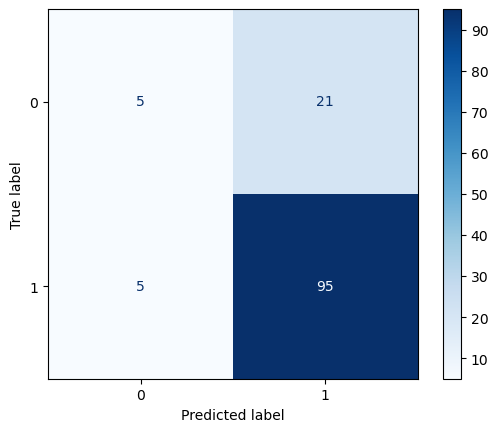

In [260]:
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap="Blues", values_format="d")

In [267]:
# Drop all columns that are clearly based on future information
# These include test_* and forecast_residual_* and curriculum_similarity
future_columns = [col for col in meta_all.columns if (
    col.startswith("test_") or 
    col.startswith("forecast_residual") or 
    col == "curriculum_similarity")
]

# Create a filtered dataframe with only train-time usable features
meta_df_live = meta_all.drop(columns=future_columns)

# Drop non-numeric and non-feature columns (like hashes or IDs if not useful)
meta_df_live = meta_df_live.select_dtypes(include=["number"])

# Remove any columns that are fully NaN
meta_df_live = meta_df_live.dropna(axis=1, how="all")

# Drop rows with missing target
meta_df_live = meta_df_live.dropna(subset=["target"])

# Separate X and y
X_live = meta_df_live.drop(columns=["target"])
y_live = meta_df_live["target"]

# Fill missing values
imputer = SimpleImputer(strategy="mean")
X_live_imputed = pd.DataFrame(imputer.fit_transform(X_live), columns=X_live.columns)

# Split and train new base classifier
X_train, X_test, y_train, y_test = train_test_split(X_live_imputed, y_live, test_size=0.25, random_state=42)
base_clf_live = RandomForestClassifier(n_estimators=100, random_state=42)
base_clf_live.fit(X_train, y_train)

# Evaluate
y_pred = base_clf_live.predict(X_test)
y_proba = base_clf_live.predict_proba(X_test)[:, 1]
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

(report, conf_matrix)


({'0': {'precision': 0.6086956521739131,
   'recall': 0.6829268292682927,
   'f1-score': 0.6436781609195402,
   'support': 41.0},
  '1': {'precision': 0.8839285714285714,
   'recall': 0.8461538461538461,
   'f1-score': 0.8646288209606987,
   'support': 117.0},
  'accuracy': 0.8037974683544303,
  'macro avg': {'precision': 0.7463121118012422,
   'recall': 0.7645403377110694,
   'f1-score': 0.7541534909401195,
   'support': 158.0},
  'weighted avg': {'precision': 0.812507370862489,
   'recall': 0.8037974683544303,
   'f1-score': 0.807293523101917,
   'support': 158.0}},
 array([[28, 13],
        [18, 99]], dtype=int64))

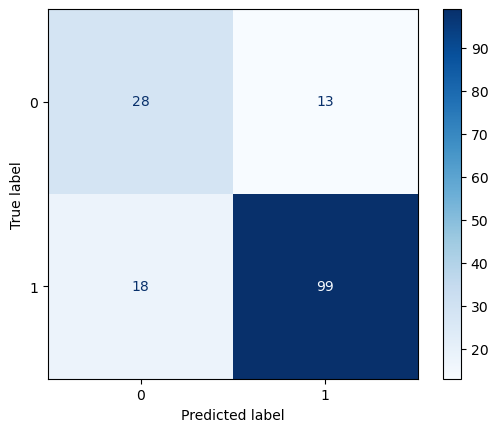

In [268]:
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap="Blues", values_format="d")

In [263]:
future_columns

['curriculum_similarity',
 'forecast_residual_mean',
 'forecast_residual_std',
 'forecast_residual_skew',
 'forecast_residual_kurtosis',
 'forecast_residual_acf1',
 'forecast_residual_ljung_pval']

In [264]:
meta_df_live.columns

Index(['train_episode_id', 'train_resid_oracle_median',
       'train_resid_market_skew', 'train_sharpe', 'train_resid_market_acf1',
       'train_market_calmar', 'train_ljung_oracle_pval',
       'train_market_sortino', 'train_wallet', 'train_resid_market_min',
       'train_resid_market_max', 'train_resid_oracle_acf1',
       'train_resid_market_kurtosis', 'train_resid_market_std',
       'train_ljung_market_pval', 'target'],
      dtype='object')

In [275]:
y_test.iloc[i]

1

In [292]:
g = 0
b = 0
for i in range(len(y_proba)):
    proba = y_proba[i]
    if proba > 0.8:
        if y_test.iloc[i]== 1:
            g +=1
        else:
            b +=1
    if proba < 0.2:
        if y_test.iloc[i]== 0:
            g +=1
        else:
            b +=1
g,b

(83, 0)